# GAN生成二次元头像 

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import os
import matplotlib.image as mpimg

Config类为变量类，用于定义在本次实验中将用到的所有参数
- img_size:读入图片的大小（长/宽）
- data_dir:训练用数据集所在路径
- glr:生成器学习率
- dlr:判别器学习率
- betal:Adam优化器的beta参数，用于调整动量项的平滑度
- nz:噪声向量的维度，用于定义生成器输入噪声的大小
- ngf:噪声向量的维度，用于定义生成器输入噪声的大小
- ndf;判别器的卷积核个数，用于定义判别器卷积层的特征图数量
- d_every:判别器的训练频率，指定每次更新判别器参数的间隔步数
- g_every:生成器的训练频率，指定每次更新生成器参数的间隔步数
- gen_num:生成图片的数量，用于定义每次生成并保存的图片数量
- gen_search_num:生成搜索数量，用于设定生成器生成图片时的搜索空间大小

In [2]:
class Config(object):
    data_dir = '../../data/extra_data'
    img_size = 96
    batch_size = 256
    epochs = 100
    glr = 2e-5
    dlr = 2e-5
    betal = 0.5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    nz = 100
    ngf = 64  
    ndf = 64  
    save_path = "./result/GAN"
    d_every = 1
    g_every = 1
    gen_img = "./result/GAN/"
    gen_num = 64
    gen_search_num = 512
    gen_mean = 0  
    gen_std = 1  
    g_loss_list,d_loss_list=[],[]
    path="./result/GAN"

生成器模型通过一系列的反卷积操作，逐步将输入的低维随机噪声转换为高维的RGB图像。每个反卷积层后都跟随批量归一化和ReLU激活函数，以提高模型的稳定性和表达能力，并在最后一层使用Tanh激活函数将输出限制在合理的范围内。
- 模型结构：
-    重复以下结构四次：
-    反卷积层：通道数逐步减半，尺寸逐步扩大
-    批量归一化层
-    ReLU激活函数
-    最后一层：
-    反卷积层：将特征图转换为RGB图像
-    并通过Tanh激活函数将输出限制在[-1, 1]之间，更加适用于图像数据。

In [3]:
class Generator(nn.Module):
    def __init__(self, opt: Config):
        super(Generator, self).__init__()
        self.ngf = opt.ngf
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(in_channels=opt.nz, out_channels=self.ngf * 8, kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.ngf * 8, out_channels=self.ngf * 4, kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.ngf * 4, out_channels=self.ngf * 2, kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.ngf * 2, out_channels=self.ngf, kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=self.ngf, out_channels=3, kernel_size=5, stride=3, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, X):
        return self.generate(X)

判别器模型通过一系列卷积层和LeakyReLU激活函数，逐步将输入的图像转换为单一的标量，并通过Sigmoid函数将该值映射到[0, 1]的概率范围内表示输入图像的真假程度，用于二分类判断。
- 模型结构：
-    后续层：重复以下结构三次：
-    卷积层：通道数逐步翻倍，特征图尺寸逐步缩小。
-    批量归一化层。
-    LeakyReLU激活函数。
-    最后一层：卷积层
-    Sigmoid激活函数：将输出值映射到[0, 1]的概率范围内，表示输入图像为真实图像的概率。
- LeakyReLU激活函数：LeakyReLU允许负数部分有一个小的梯度，使得梯度不会完全消失，从而有效避免神经元“死亡”的问题

In [4]:
class Discriminator(nn.Module):
    def __init__(self, opt: Config):
        super(Discriminator, self).__init__()
        self.ndf = opt.ndf
        self.Discrim = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.ndf, kernel_size=5, stride=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=self.ndf, out_channels=self.ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels=self.ndf * 2, out_channels=self.ndf * 4, kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels=self.ndf * 4, out_channels=self.ndf * 8, kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels=self.ndf * 8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.Discrim(x).view(-1)

EVAL函数用于评估生成器与判别器模型的效果
- 将生成器与判别器设置为eval模式
- 生成经过标准化的noise矩阵作为生成器的输入来生成图像
- 将生成的fake_image输入进判别器用于获得生成图像的得分
- 从分数张量中获得前 opt.gen_num 个最大的值的位置索引
- 将对应图片添加至result列表后，将所有图片存入"./result"路径下，并将图片命名为对应的时间步
- 将所有图片读入并展示

In [5]:
@torch.no_grad()
def eval(opt: Config, netG, netD):
    device = opt.device
    netG.eval()
    netD.eval()
    netG.to(device)
    netD.to(device)
    noise = torch.randn(opt.gen_search_num, opt.nz, 1, 1).normal_(opt.gen_mean, opt.gen_std).to(device)
    fake_image = netG(noise)
    score = netD(fake_image).detach()
    index = score.topk(opt.gen_num)[1]
    result = []
    for i in index:
        result.append(fake_image.data[i])
    # 以opt.gen_img为文件名保存生成图片
    torchvision.utils.save_image(torch.stack(result), opt.gen_img+"final.png", normalize=True)
    I = mpimg.imread( opt.gen_img+"final.png")
    plt.imshow(I)
    plt.title("final")
    plt.axis('off') 
    plt.show()


定义TRAIN函数用于创建生成器模型、判别器模型、评估模型性能并返回对应模型变量
- 首先定义对加载图像的处理方式：重定义图片大小、中心裁切、转化为向量、图像标准化
- 根据数据集所在文件夹目录读取文件夹目录下的所有图片数据并创建dataset实例，并根据dataset创建可迭代数据加载器用于训练模型
- 根据全局变量类实例创建生成器模型netG与判别器模型netD
- 将生成器模型与判别器模型转移至"GPU/CPU"并将模型设置为训练模式
- 根据opt分别创建生成器、判别器Adam参数优化器与Loss函数，并根据batch_size大小生成正、反标签与noise张量供生成器生成
- 训练模型
-   根据数据集遍历情况分别对生成器、判别器进行参数优化
-   生成器：
-   清除生成器梯度，以准备计算新一轮的梯度
-   将真实图像传入判别器获得得分后计算loss并进行反向传播计算梯度
-   根据noise生成图像，并将其传入判别器用于计算结果并进行反向传播计算梯度
-    更新生成器的参数
-   判别器：
-    清除生成器梯度，以准备计算新一轮的梯度
-    生成服从正态分布的随机噪声，用于作为生成器的输入
-    通过生成器模型 netG，将随机噪声输入转换为生成的假图像
-    将生成的假图像输入到判别器模型 netD 中，获得判别器的输出
-    计算生成器的损失并通过反向传播，计算生成器的梯度
-    更新生成器的参数
- 每50个epoch对生成器与判别器进行一次模型评估
- 返回最终训练所得的生成器、判别器模型

In [6]:
def train(opt: Config):
    transformers = torchvision.transforms.Compose([
        torchvision.transforms.Resize((opt.img_size, opt.img_size)),
        torchvision.transforms.CenterCrop(opt.img_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    device = opt.device
    dataset = torchvision.datasets.ImageFolder(root=opt.data_dir, transform=transformers)
    dataloader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True,drop_last=True)
    netG, netD = Generator(opt), Discriminator(opt)
    netG.to(opt.device)
    netD.to(opt.device)
    netG.train()
    netD.train()
    optimize_g = torch.optim.Adam(netG.parameters(), lr=opt.glr)
    optimize_d = torch.optim.Adam(netD.parameters(), lr=opt.dlr)
    criterion = nn.BCELoss().to(device)
    true_labels = torch.ones(opt.batch_size).to(device)
    fake_labels = torch.zeros(opt.batch_size).to(device)
    noise = torch.randn(opt.batch_size, opt.nz, 1, 1, device=opt.device)
    fix_noises = torch.randn(opt.batch_size, opt.nz, 1, 1).to(device)
    for epoch in tqdm(range(opt.epochs)):
        total_g_loss,total_d_loss=0,0
        netG.train()
        netD.train()
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            if i % opt.d_every == 0:
                optimize_d.zero_grad()
                output = netD(images)
                loss = criterion(output, true_labels)
                loss.backward()
                noise = noise.detach()
                fake_images = netG(noise).detach()
                output = netD(fake_images)
                loss_d = criterion(output, fake_labels)
                loss_d.backward()
                optimize_d.step()
                total_d_loss+=loss_d.item()+loss.item()
            if i % opt.g_every == 0:
                optimize_g.zero_grad()
                noise.data.copy_(torch.randn(opt.batch_size, opt.nz, 1, 1, device=opt.device))
                fake_images = netG(noise)
                output = netD(fake_images)
                loss_g = criterion(output, true_labels)
                loss_g.backward()
                optimize_g.step()
                total_g_loss+=loss_g.item()
        opt.d_loss_list.append(total_d_loss)
        opt.g_loss_list.append(total_g_loss)
        if (epoch+1) % 20 == 0:
            if not os.path.exists(opt.save_path):
                os.makedirs(opt.save_path)
            print(f'epoch:{epoch+1}  G_Loss:{total_g_loss} D_Loss:{total_d_loss}')
            fix_fake_image = netG(fix_noises)
            torchvision.utils.save_image(fix_fake_image.data[:64], "%s/%s.png" % (opt.save_path, epoch+1), normalize=True)
            I = mpimg.imread( "%s/%s.png" % (opt.save_path, epoch+1))
            plt.imshow(I)
            plt.title(f'epoch:{epoch+1}')
            plt.axis('off') 
            plt.show()
    return netG, netD

创建全局变量类实例，并获取训练后的生成器、判别器模型

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\23225\anaconda3\envs\dl\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\23225\anaconda3\envs\dl\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 19%|█▉        | 19/100 [12:20<50:52, 37.68s/it] 

epoch:20  G_Loss:1085.5789394378662 D_Loss:0.7999289063445758


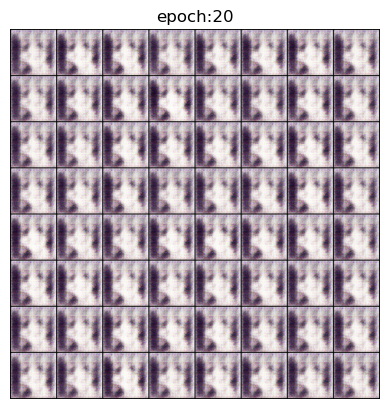

 39%|███▉      | 39/100 [24:54<38:22, 37.75s/it]

epoch:40  G_Loss:909.4235649108887 D_Loss:2.8231240999302827


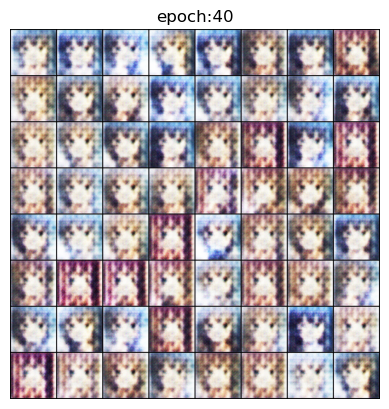

 59%|█████▉    | 59/100 [37:17<25:17, 37.00s/it]

epoch:60  G_Loss:1063.7181196212769 D_Loss:4.379361576080555


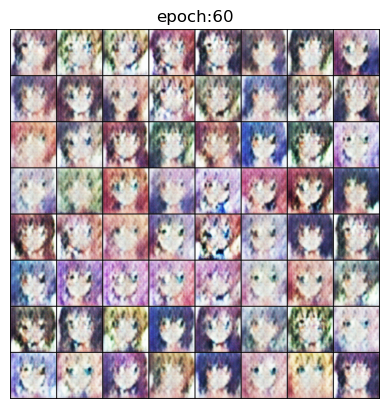

 79%|███████▉  | 79/100 [49:46<13:06, 37.47s/it]

epoch:80  G_Loss:906.2800874710083 D_Loss:7.052171527640894


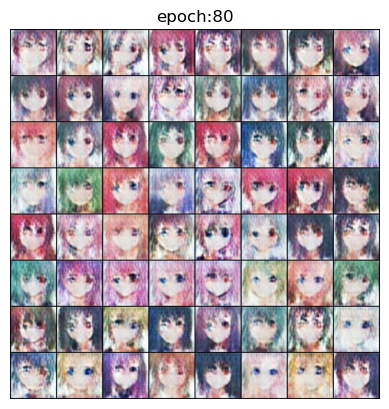

 99%|█████████▉| 99/100 [1:02:22<00:38, 38.36s/it]

epoch:100  G_Loss:898.0716595649719 D_Loss:6.665292532648891


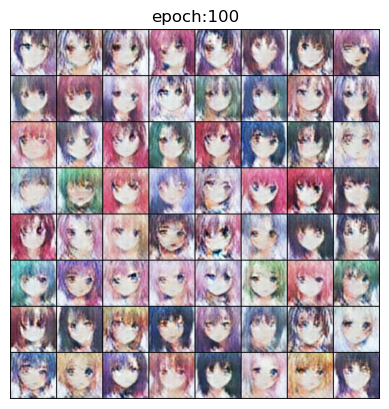

100%|██████████| 100/100 [1:03:00<00:00, 37.81s/it]


In [7]:
opt = Config()
netG, netD = train(opt)

本段代码生成从1至epoch的时间步序列，用于之后相关图像的绘制

In [8]:
length = len(opt.d_loss_list)
x=[i+1 for i in range(length)]

本段代码用于将已经记录的生成器损失列表(g_loss_list)以及判别器损失列表(d_loss_list)绘制成图像，便于直观理解与比较

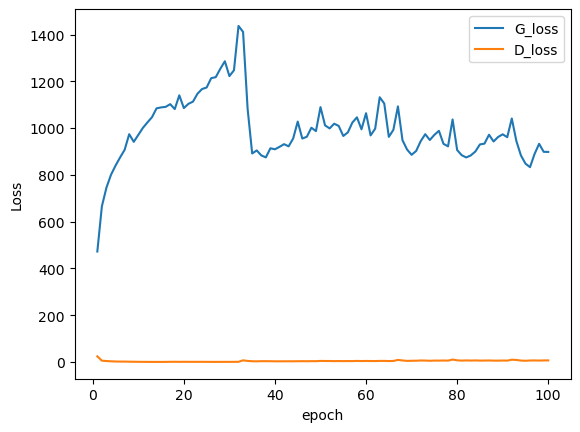

In [9]:
plt.plot(x, opt.g_loss_list,label='G_loss')
plt.plot(x, opt.d_loss_list,label='D_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

最终评估模型性能

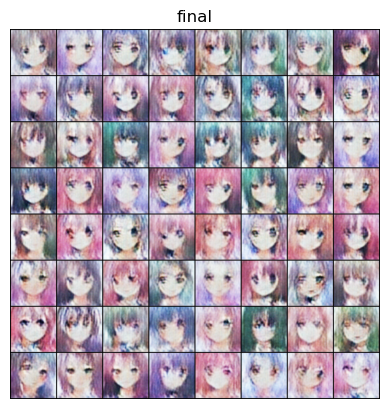

In [10]:
eval(opt,netG,netD)